In [2]:
import wandb
from data_preparation import *
import distutils.version
import torchvision
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from pathlib import Path
from model import *

transforms = LRImgTransforms(64)
target_transforms = HRImgTransforms(128)

path = '../../DIV2K_train_HR'

train_ds = CustomSuperResolutionDataset(path,\
                                        transform=transforms.transforms,\
                                        target_transform=target_transforms.transforms)

train_size = int(0.8 * len(train_ds))
val_size = len(train_ds) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_ds, [train_size, val_size])

train_dl = DataLoader(train_dataset, 32, shuffle=True)
val_dl = DataLoader(val_dataset, 32, shuffle=True)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/users/nfs/Etu4/28709864/ML/lib/python3.9/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

In [13]:
class State :
    def __init__ (self, model, optim, scheduler):
        self.model = model
        self.optim = optim
        self.scheduler = scheduler
        self.iteration = 0
        self.train_loss = []
        self.val_loss = []

In [14]:
savepath = Path("RGT.plt")

iterations = 500000
h_train = 4
h_test = 16
LR = 2e-4
milestones = [250000, 400000, 450000, 475000]
if savepath.is_file():
    with savepath.open("rb") as fp :
        state = torch.load(fp)
else:
    # model
    model = RGT(C = 180,\
            dim_in = 3,\
            N1 = 8,\
            N2 = 6,\
            cr = 0.5,\
            s_r = 4,\
            hidden_ratio = 2,\
            upscale_factor = 2
           )
    model = model.to(device)
    # optim
    optim = torch.optim.Adam(params = model.parameters(), lr = LR, betas=(0.9, 0.99))
    # scheduler
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=milestones, gamma=0.5)
    state = State(model, optim, scheduler)

# loss
loss_fn = torch.nn.L1Loss()

In [17]:
for iteration in range(state.iteration, iterations):
    if iteration % 10000 == 0:
        print(iteration)
    train_loss = 0.
    state.model.train()
    for x, x_sr in train_dl:
        # data
        x, x_sr = x.to(device), x_sr.to(device)
        # super resolution
        pred_sr = state.model(x, h_train)
        
        # loss and update
        state.optim.zero_grad()
        l = loss_fn(pred_sr, x_sr)
        l.backward()
        state.optim.step()
        state.iteration += 1
        state.scheduler.step()
        train_loss += l.item()
        
    state.train_loss.append(train_loss/len(train_dl))
        
    with savepath.open("wb") as fp :
        torch.save(state, fp)
    
    with torch.no_grad():
        state.model.eval()
        val_loss = 0.
        for x_val,x_val_sr in val_dl:
            # data
            x_val, x_val_sr = x_val.to(device), x_val_sr.to(device)
            # super resolution
            pred_val_sr = state.model(x_val, h_test)
            # loss
            l_val = loss_fn(pred_val_sr, x_val_sr)
            val_loss += l_val.item()
        state.val_loss.append(val_loss/len(val_dl))
        # visualization
        if iteration % 200 == 0:
            fig, axes = plt.subplots(2,1)
            axes = axes.flatten()
            grid_img = torchvision.utils.make_grid(pred_val_sr[:5], nrow=5)
            grid_img_HR = torchvision.utils.make_grid(x_val_sr[:5], nrow=5)
            axes[0].imshow(grid_img.permute(1, 2, 0))
            axes[0].set_title('SR')
            axes[1].imshow(grid_img_HR.permute(1, 2, 0))
            axes[1].set_title('True_HR')

RuntimeError: CUDA out of memory. Tried to allocate 768.00 MiB (GPU 0; 79.17 GiB total capacity; 13.35 GiB already allocated; 396.88 MiB free; 13.47 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

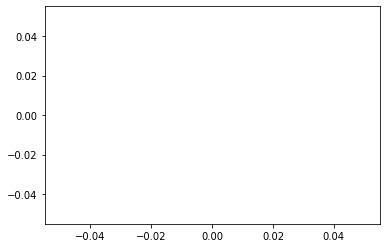

In [16]:
plt.plot(state.train_loss, np.arange(len(state.train_loss)))
plt.show()

In [ ]:
plt.plot(state.val_loss, np.arange(len(state.val_loss)))
plt.show()

In [1]:
!nvidia-smi

Sat Dec  9 02:06:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:D8:00.0 Off |                    0 |
| N/A   84C    P0   222W / 300W |  64593MiB / 81920MiB |     99%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------